In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os

In [4]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import torch
import os

class FacialDataset(Dataset):
    def __init__(self, csv_file, image_folder, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        
        # Read the CSV file
        self.data = pd.read_csv(csv_file)
        
        # Extract image filenames and features
        self.image_filenames = self.data.iloc[:, 0].tolist()
        self.features = self.data.iloc[:, 1:].values
        self.features = np.where(self.features == -1, 0, 1)  # Convert -1, 1 to 0, 1
        self.features = torch.tensor(self.features, dtype=torch.float32)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_name = self.image_filenames[idx]
        image_name_png = os.path.splitext(image_name)[0] + '.png'  # Change extension to .png
        image_path = os.path.join(self.image_folder, image_name_png)
        if not os.path.isfile(image_path):
            print(f"File not found: {image_path}")
            # Return a dummy image or handle this case differently
            return torch.zeros((3, 216, 176)), torch.zeros(self.features.size(1))
        
        try:
            image = Image.open(image_path).convert('RGB')
        except OSError as e:
            print(f"Error opening image {image_path}: {e}")
            return torch.zeros((3, 216, 176)), torch.zeros(self.features.size(1))
        
        features = self.features[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, features


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CVAE(nn.Module):
    def __init__(self, input_shape, num_features, latent_dim):
        super(CVAE, self).__init__()
        self.input_shape = input_shape
        self.num_features = num_features
        self.latent_dim = latent_dim

        # Define the encoder
        self.conv1 = nn.Conv2d(input_shape[0], 32, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.fc1 = nn.Linear(128 * 27 * 22, 512)
        self.fc2_mu = nn.Linear(512, latent_dim)
        self.fc2_logvar = nn.Linear(512, latent_dim)

        # Define the decoder
        self.fc3 = nn.Linear(latent_dim + num_features, 512)
        self.fc4 = nn.Linear(512, 128 * 27 * 22)
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(32, input_shape[0], kernel_size=4, stride=2, padding=1)

    def _get_conv_output_size(self):
        # Calculate the output size after convolutions
        x = torch.zeros(1, *self.input_shape)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x.numel()

    def encode(self, x, features):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        mu = self.fc2_mu(x)
        logvar = self.fc2_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, features):
        x = torch.cat([z, features], dim=1)
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = x.view(x.size(0), 128, 27, 22)  # Reshape to (batch_size, 128, 27, 22)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = torch.sigmoid(self.deconv3(x))  # Use sigmoid for the output layer
        return x

    def forward(self, x, features):
        mu, logvar = self.encode(x, features)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, features)
        return recon_x, mu, logvar


In [6]:
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    # KLD is the KL divergence loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [7]:
transform = transforms.Compose([
    transforms.Resize((216, 176)),
    transforms.ToTensor(),
])

# Paths
csv_file = r'E:\projects\VAE\codes\celeba\filtered_labels.csv'
image_folder = r'E:\projects\VAE\data\img_align_celeba_png\train'

# Create dataset and dataloader
dataset = FacialDataset(csv_file=csv_file, image_folder=image_folder, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


In [9]:
# # Hyperparameters
# img_channels = 3
# feature_dim = dataset.features.shape[1]  # Number of features
# latent_dim = 128
# learning_rate = 1e-3
# num_epochs = 50

# # Initialize model and optimizer
# input_shape = (218, 178, 3)
# model = CVAE(input_shape=input_shape, num_features=feature_dim, latent_dim=latent_dim).cuda()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# # Training loop
# for epoch in range(num_epochs):
#     model.train()
#     total_loss = 0
#     for images, features in dataloader:
#         images, features = images.cuda(), features.cuda()
        
#         # Forward pass
#         recon_images, mu, logvar = model(images, features)
        
#         # Compute loss
#         loss = loss_function(recon_images, images, mu, logvar)
#         total_loss += loss.item()
        
#         # Backpropagation and optimization
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
    
#     average_loss = total_loss / len(dataloader)
#     print(f'Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}')

# Hyperparameters
img_channels = 3  # Number of channels in the input image (RGB)
img_height = 216  # Height of the input image
img_width = 176   # Width of the input image
latent_dim = 128  # Dimensionality of the latent space
learning_rate = 1e-3  # Learning rate for the optimizer
num_epochs = 10  # Number of epochs to train
batch_size = 16  # Batch size for training

# Transformations for image data
transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
])

# Initialize dataset and dataloader
dataset = FacialDataset(
    csv_file=r'E:\projects\VAE\codes\celeba\filtered_labels.csv', 
    image_folder=r'E:\projects\VAE\data\img_align_celeba_png\train',
    transform=transform
)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model setup
input_shape = (img_channels, img_height, img_width)
feature_dim = dataset.features.shape[1]  # Number of features in the CSV

model = CVAE(input_shape=input_shape, num_features=feature_dim, latent_dim=latent_dim).cuda()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, features in dataloader:
        images, features = images.cuda(), features.cuda()

        # Forward pass
        recon_images, mu, logvar = model(images, features)

        # Compute loss
        loss = loss_function(recon_images, images, mu, logvar)
        total_loss += loss.item()

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    average_loss = total_loss / len(dataloader)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}')


File not found: E:\projects\VAE\data\img_align_celeba_png\train\162771.png
Epoch 1/10, Loss: 949942.6602
File not found: E:\projects\VAE\data\img_align_celeba_png\train\162771.png
Epoch 2/10, Loss: 927017.8749
File not found: E:\projects\VAE\data\img_align_celeba_png\train\162771.png
Epoch 3/10, Loss: 921442.0479
File not found: E:\projects\VAE\data\img_align_celeba_png\train\162771.png
Epoch 4/10, Loss: 918082.7776
File not found: E:\projects\VAE\data\img_align_celeba_png\train\162771.png
Epoch 5/10, Loss: 915862.4842
File not found: E:\projects\VAE\data\img_align_celeba_png\train\162771.png
Epoch 6/10, Loss: 914291.3444
File not found: E:\projects\VAE\data\img_align_celeba_png\train\162771.png
Epoch 7/10, Loss: 913034.7198
File not found: E:\projects\VAE\data\img_align_celeba_png\train\162771.png
Epoch 8/10, Loss: 911946.6037
File not found: E:\projects\VAE\data\img_align_celeba_png\train\162771.png
Epoch 9/10, Loss: 911014.9986
File not found: E:\projects\VAE\data\img_align_celeba_p

In [10]:
import os

# Define the directory and filename
model_directory = r'E:/projects/VAE/codes/celeba'
model_filename = 'cvae_model_entire.pth'
entire_model_save_path = os.path.join(model_directory, model_filename)

# Ensure the directory exists
os.makedirs(model_directory, exist_ok=True)

# Save the entire model
torch.save(model, entire_model_save_path)

print(f"Entire model saved to {entire_model_save_path}")


Entire model saved to E:/projects/VAE/codes/celeba\cvae_model_entire.pth


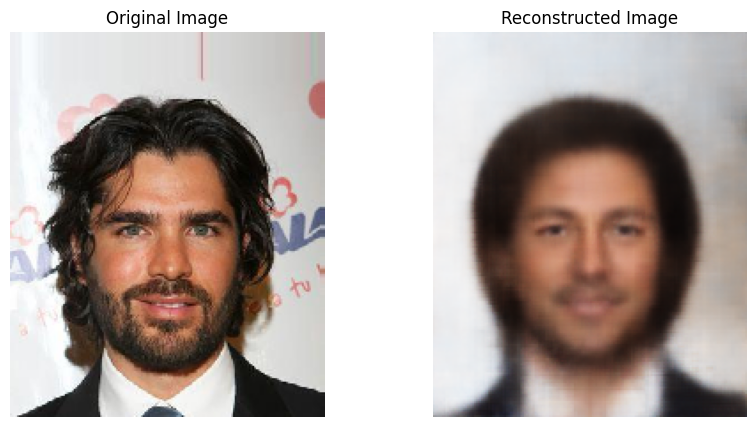

In [14]:
import os
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# Define transformation
transform = transforms.Compose([
    transforms.Resize((218, 178)),
    transforms.ToTensor(),
])

# Path to the single image
image_path = 'E:/projects/VAE/data/img_align_celeba_png/test/162772.png'

# Load and preprocess the image
image = Image.open(image_path).convert('RGB')
image = transform(image).unsqueeze(0)  # Add batch dimension
image = image.cuda()  # Move to GPU if needed

# Define a dummy feature vector for the image
dummy_features = torch.zeros((1, feature_dim)).cuda()

# Load the saved model
model = torch.load(entire_model_save_path)
model.eval()  # Set the model to evaluation mode
model = model.cuda()  # Move to GPU if needed

# Perform inference
with torch.no_grad():
    recon_image, _, _ = model(image, dummy_features)

# Convert tensor to image
recon_image = recon_image.squeeze().cpu()  # Remove batch dimension and move to CPU
recon_image = transforms.ToPILImage()(recon_image)

# Convert the original image for display
original_image = transforms.ToPILImage()(image.squeeze().cpu())

# Display original and reconstructed images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(original_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Reconstructed Image')
plt.imshow(recon_image)
plt.axis('off')

plt.show()


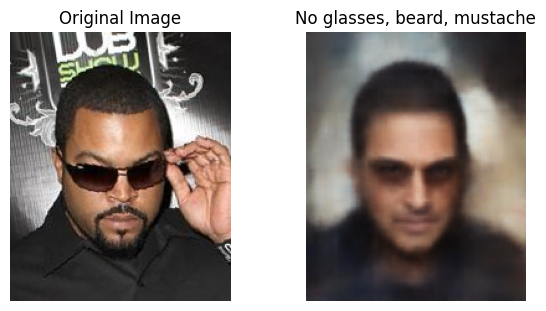

In [87]:
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# Define transformation
transform = transforms.Compose([
    transforms.Resize((218, 178)),
    transforms.ToTensor(),
])

# Define the path to the image
# image_path = 'E:/projects/VAE/data/img_align_celeba_png/test/163164.png'
image_path = 'E:/projects/VAE/data/img_align_celeba_png/test/162956.png'

# Load and preprocess the image
image = Image.open(image_path).convert('RGB')
image = transform(image).unsqueeze(0).cuda()  # Add batch dimension and move to GPU

# Define the new condition vector
# Attractive,Bald,Smiling,Wearing_Lipstick,Young,Eyeglasses,Heavy_Makeup,Mustache,No_Beard,Receding_Hairline
conditions = [0,0,0,0,0,0,0,1,1,0]  # Example conditions
# conditions = [1,1,1,1,1,1,1,1,1,1]  # Example conditions
condition_tensor = torch.tensor(conditions, dtype=torch.float32).unsqueeze(0).cuda()

# Load the saved model
model = torch.load('E:\projects\VAE\codes\celeba\cvae_model_entir.pth')
model.eval()  # Set the model to evaluation mode
model = model.cuda()  # Move to GPU if needed

# Perform inference
with torch.no_grad():
    recon_image, _, _ = model(image, condition_tensor)

# Convert tensor to image
recon_image = recon_image.squeeze().cpu()  # Remove batch dimension and move to CPU
recon_image = transforms.ToPILImage()(recon_image)

# Convert the original image for display
original_image = transforms.ToPILImage()(image.squeeze().cpu())

# Display original and reconstructed images with new conditions
plt.figure(figsize=(7, 3.5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(original_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('No glasses, beard, mustache')
plt.imshow(recon_image)
plt.axis('off')

plt.show()


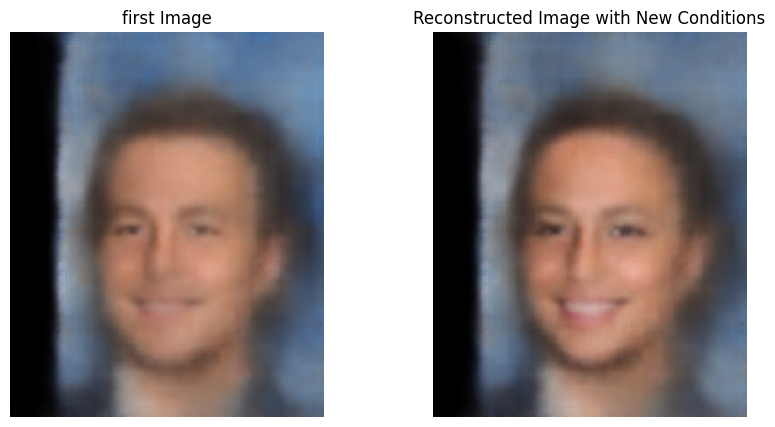

In [19]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('first Image')
plt.imshow(first)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Reconstructed Image with New Conditions')
plt.imshow(recon_image)
plt.axis('off')

plt.show()